# Question 1 #

To pinpoint specific geographic locations and temporal patterns where accidents occur most frequently, enabling targeted measures to enhance road safety.

## Import data

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Accident Hotspots Analysis") \
    .getOrCreate()

df = spark.read.csv('Road.csv', header=True, inferSchema=True)

23/12/19 15:30:52 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
df.columns

['Time',
 'Day_of_week',
 'Age_band_of_driver',
 'Sex_of_driver',
 'Educational_level',
 'Vehicle_driver_relation',
 'Driving_experience',
 'Type_of_vehicle',
 'Owner_of_vehicle',
 'Service_year_of_vehicle',
 'Defect_of_vehicle',
 'Area_accident_occured',
 'Lanes_or_Medians',
 'Road_allignment',
 'Types_of_Junction',
 'Road_surface_type',
 'Road_surface_conditions',
 'Light_conditions',
 'Weather_conditions',
 'Type_of_collision',
 'Number_of_vehicles_involved',
 'Number_of_casualties',
 'Vehicle_movement',
 'Casualty_class',
 'Sex_of_casualty',
 'Age_band_of_casualty',
 'Casualty_severity',
 'Work_of_casuality',
 'Fitness_of_casuality',
 'Pedestrian_movement',
 'Cause_of_accident',
 'Accident_severity']

In [4]:
df.count()

12316

# Correlation Analysis - Categorical Data

perform_chi_square_test

In [28]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

def perform_chi_square_test(df, column1, column2):
    """
    Perform a Chi-Square test on two categorical columns of a PySpark DataFrame.

    Args:
    df (DataFrame): PySpark DataFrame.
    column1 (str): Name of the first column.
    column2 (str): Name of the second column.

    Returns:
    p value
    """
    # Create the contingency table
    contingency_table = df.groupBy(column1, column2).count()

    # Convert to Pandas DataFrame for chi-square test
    contingency_pd = contingency_table.toPandas()
    contingency_pd_pivot = contingency_pd.pivot(index=column1, columns=column2, values='count').fillna(0)

    # Perform the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)
    
    # Return
    return p

chi_square_test_on_features

In [29]:
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def chi_square_test_on_features(df: DataFrame, target_column: str, significance_level: float) -> list:
    """
    Filters the target column in a PySpark DataFrame, iterates over each feature column,
    performs chi-square tests, plots the results, and returns the list of test results.

    :param df: PySpark DataFrame to be used.
    :param target_column: The target column for chi-square tests.
    :param significance_level: The significance level for the chi-square test.
    :return: List of tuples containing column names, test results, and p-values.
    """
    # Filter the target column
    df = df.filter(
        df[target_column].isNotNull() & 
        (~df[target_column].isin(['unknown', 'Unknown', 'Other', 'other', 'na', 'normalNormal']))
    )

    test_results = []

    # Iterate over each feature column
    for column in df.columns:
        if column != target_column:
            # Filter the feature column
            df_filtered = df.filter(
                df[column].isNotNull() & 
                (~df[column].isin(['unknown', 'Unknown', 'Other', 'other', 'na', 'normalNormal']))
            )

            # Perform chi-square test (assuming perform_chi_square_test is defined)
            p = perform_chi_square_test(df_filtered, column, target_column)

            # Compare p-value with significance level and determine the result
            result = 'Dependent (reject H0)' if p <= significance_level else 'Independent (H0 holds true)'

            # Append column name, result, and p-value to the list
            test_results.append((column, result, p))

    # Plotting the results
    plot_df = pd.DataFrame(test_results, columns=['Feature', 'Result', 'P-Value'])

    # Set the figure size
    plt.figure(figsize=(10, len(plot_df['Feature']) / 2))

    # Horizontal bar chart
    sns.barplot(x='P-Value', y='Feature', data=plot_df)
    plt.title('P-Values of Features')
    plt.show()

    # Return the list of test results
    return test_results

/usr/local/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/usr/local/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


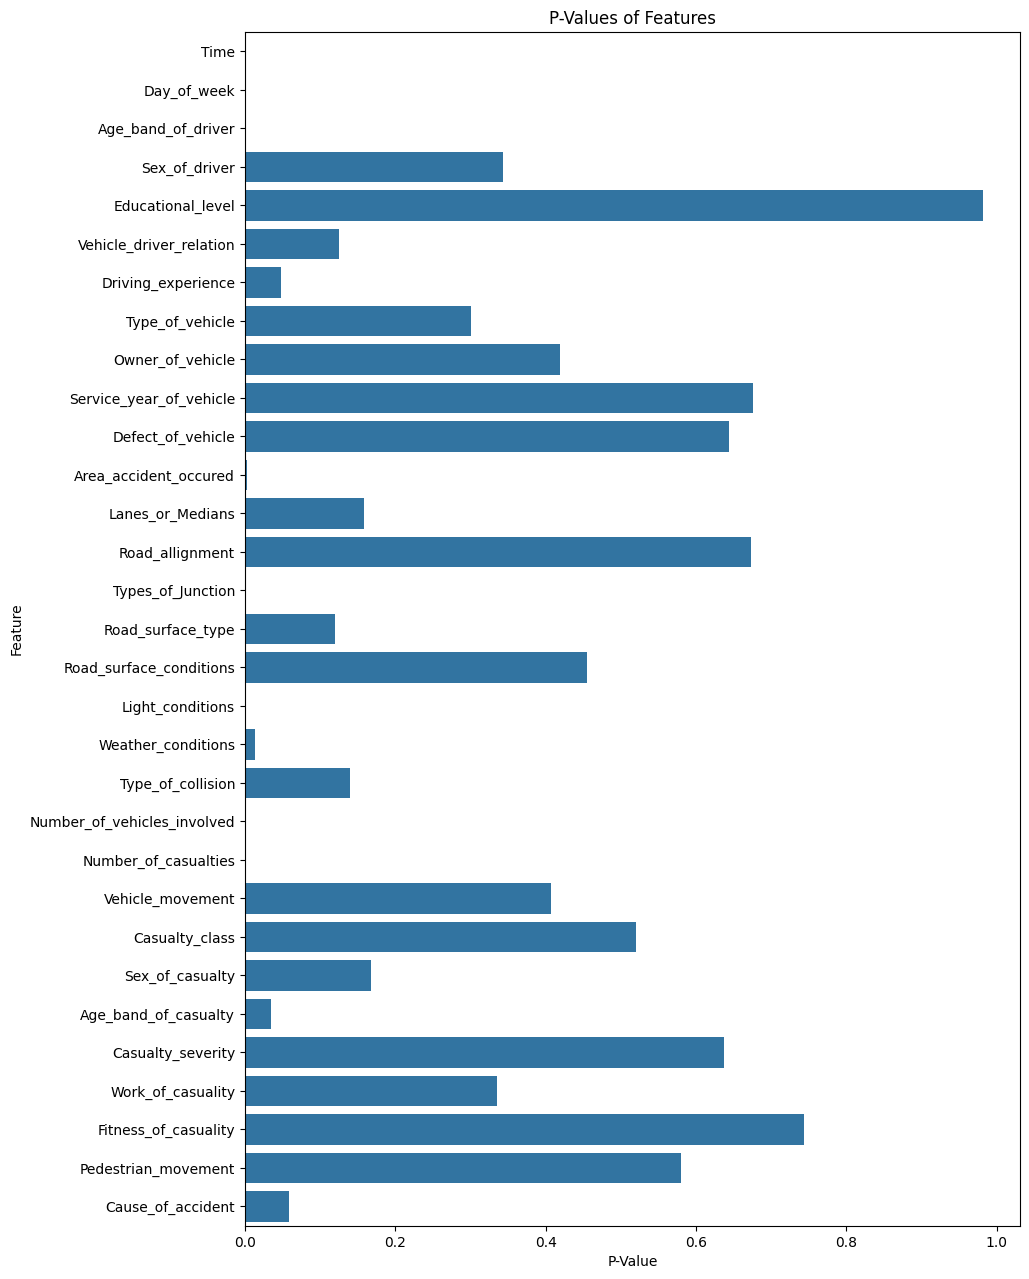

                        Feature                       Result       P-Value
0                          Time        Dependent (reject H0)  0.000000e+00
21         Number_of_casualties        Dependent (reject H0)  2.045418e-67
20  Number_of_vehicles_involved        Dependent (reject H0)  3.013343e-62
17             Light_conditions        Dependent (reject H0)  4.627954e-08
14            Types_of_Junction        Dependent (reject H0)  4.287789e-06
1                   Day_of_week        Dependent (reject H0)  4.300319e-06
2            Age_band_of_driver        Dependent (reject H0)  7.452442e-06
11        Area_accident_occured        Dependent (reject H0)  3.205199e-03
18           Weather_conditions        Dependent (reject H0)  1.387240e-02
25         Age_band_of_casualty        Dependent (reject H0)  3.431907e-02
6            Driving_experience        Dependent (reject H0)  4.833484e-02
30            Cause_of_accident  Independent (H0 holds true)  5.875545e-02
15            Road_surfac

In [30]:
import pandas as pd


# Call the chi_square_test_on_features function
test_results = chi_square_test_on_features(df, 'Accident_severity', 0.05)

# Create a Pandas DataFrame from the list for table display
results_df = pd.DataFrame(test_results, columns=['Feature', 'Result', 'P-Value'])
results_df = results_df.sort_values(by='P-Value', ascending=True)

# Display the table
print(results_df)


## Sex_of_driver vs Accident_severity (Not statistically Significant)
If a correlation is found, it might suggest that certain driver demographics are more prone to be involved in severe accidents in specific areas. This can lead to targeted safety programs or interventions focused on these demographics.

In [19]:
from pyspark.sql import SparkSession, functions as F

# Initialize Spark Session (if not already initialized)
spark = SparkSession.builder.appName("DataTransform").getOrCreate()

# clean and run chi square test for all features
clean_and_chiSqaure(df, 'Sex_of_driver', 'Accident_severity')

# p_values = chi_square_test_on_features(df, 'Accident_severity')



Accident_severity - Independent (H0 holds true)


## Educational_level vs Accident_severity (>P, Weak Association)
Correlation here could indicate the need for educational campaigns or driver safety programs tailored to different education levels, potentially reducing accident severity in specific regions.

In [ ]:
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df.filter(df['Educational_level'].isNotNull() & (df['Educational_level'] != 'unknown') & (df['Educational_level'] != 'Unknown'))
df_filter = df_filter.filter(df_filter['Accident_severity'].isNotNull() & (df_filter['Accident_severity'] != 'unknown') & (df_filter['Accident_severity'] != 'Unknown'))

In [ ]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Assuming df is your PySpark DataFrame
# Create the contingency table
contingency_table = df.groupBy('Educational_level', 'Accident_severity').count()

# Convert to Pandas DataFrame for chi-square test
contingency_pd = contingency_table.toPandas()
contingency_pd_pivot = contingency_pd.pivot(index='Educational_level', columns='Accident_severity', values='count').fillna(0)

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)

# Output the results
print(chi2, p, dof, expected)

## Day_of_week vs Type_of_collision (<P, but not related to accident frequency or location)
Identifying days with higher frequencies of certain types of collisions can inform scheduling for increased road safety measures or traffic enforcement on those specific days.

In [ ]:
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df.filter(df['Day_of_week'].isNotNull() & (df['Day_of_week'] != 'unknown') & (df['Day_of_week'] != 'Unknown'))
df_filter = df_filter.filter(df_filter['Type_of_collision'].isNotNull() & (df_filter['Type_of_collision'] != 'Other'))

In [ ]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Assuming df is your PySpark DataFrame
# Create the contingency table
contingency_table = df.groupBy('Day_of_week', 'Type_of_collision').count()

# Convert to Pandas DataFrame for chi-square test
contingency_pd = contingency_table.toPandas()
contingency_pd_pivot = contingency_pd.pivot(index='Day_of_week', columns='Type_of_collision', values='count').fillna(0)

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)

# Output the results
print(chi2, p, dof, expected)

## *Weather_conditions vs Accident_severity*
This correlation can help in predicting accident severity based on weather conditions. It can guide the deployment of weather-specific road safety measures in areas prone to severe weather-related accidents.

In [ ]:
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df.filter(df['Weather_conditions'].isNotNull() & (df['Weather_conditions'] != 'Other') & (df['Weather_conditions'] != 'Unknown'))
df_filter = df_filter.filter(df_filter['Accident_severity'].isNotNull() & (df_filter['Accident_severity'] != 'unknown') & (df_filter['Accident_severity'] != 'Unknown'))

In [ ]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Assuming df is your PySpark DataFrame
# Create the contingency table
contingency_table = df.groupBy('Weather_conditions', 'Accident_severity').count()

# Convert to Pandas DataFrame for chi-square test
contingency_pd = contingency_table.toPandas()
contingency_pd_pivot = contingency_pd.pivot(index='Weather_conditions', columns='Accident_severity', values='count').fillna(0)

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)

# Output the results
print(chi2, p, dof, expected)

## *Light_conditions vs Accident_severity*
Understanding how light conditions affect accident severity can inform infrastructure improvements (like street lighting) in specific areas, and help in scheduling increased patrolling during high-risk light conditions.

In [ ]:
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df
df_filter = df_filter.filter(df_filter['Accident_severity'].isNotNull() & (df_filter['Accident_severity'] != 'unknown') & (df_filter['Accident_severity'] != 'Unknown'))

In [ ]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Assuming df is your PySpark DataFrame
# Create the contingency table
contingency_table = df.groupBy('Light_conditions', 'Accident_severity').count()

# Convert to Pandas DataFrame for chi-square test
contingency_pd = contingency_table.toPandas()
contingency_pd_pivot = contingency_pd.pivot(index='Light_conditions', columns='Accident_severity', values='count').fillna(0)

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)

# Output the results
print(chi2, p, dof, expected)

## *Road_surface_conditions vs Accident_severity*
Knowing how road conditions influence accident severity can guide maintenance and infrastructure development in specific geographic locations to improve road safety.

In [ ]:
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df
df_filter = df_filter.filter(df_filter['Accident_severity'].isNotNull() & (df_filter['Accident_severity'] != 'unknown') & (df_filter['Accident_severity'] != 'Unknown'))

In [ ]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Assuming df is your PySpark DataFrame
# Create the contingency table
contingency_table = df.groupBy('Road_surface_conditions', 'Accident_severity').count()

# Convert to Pandas DataFrame for chi-square test
contingency_pd = contingency_table.toPandas()
contingency_pd_pivot = contingency_pd.pivot(index='Road_surface_conditions', columns='Accident_severity', values='count').fillna(0)

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)

# Output the results
print(chi2, p, dof, expected)

## *Type_of_vehicle vs Accident_severity*
This correlation can inform targeted vehicle safety standards or advisories for certain vehicle types, especially in areas where these vehicles are involved in more severe accidents.

In [ ]:
from pyspark.sql import functions as F
import pandas as pd

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df.filter(df['Type_of_vehicle'].isNotNull() & (df['Type_of_vehicle'] != 'Other') & (df['Type_of_vehicle'] != 'Bajaj'))
# Assuming df_filter is your PySpark DataFrame
df_filter = df_filter.withColumn("Type_of_vehicle", F.regexp_replace(F.col("Type_of_vehicle"), r"\s\(.*\)", ""))

df_filter = df_filter.filter(df_filter['Accident_severity'].isNotNull() & (df_filter['Accident_severity'] != 'unknown') & (df_filter['Accident_severity'] != 'Unknown'))

In [ ]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Assuming df is your PySpark DataFrame
# Create the contingency table
contingency_table = df.groupBy('Type_of_vehicle', 'Accident_severity').count()

# Convert to Pandas DataFrame for chi-square test
contingency_pd = contingency_table.toPandas()
contingency_pd_pivot = contingency_pd.pivot(index='Type_of_vehicle', columns='Accident_severity', values='count').fillna(0)

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)

# Output the results
print(chi2, p, dof, expected)

## *Area_accident_occurred vs Accident_severity*
Identifying areas prone to severe accidents is directly related to your goal. This information can be used to focus road safety improvements, traffic regulation changes, or public awareness campaigns in these specific locations.

In [ ]:
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df.filter(df['Area_accident_occured'].isNotNull() & (df['Area_accident_occured'] != 'Other') & (df['Area_accident_occured'] != 'Unknown') & (df['Area_accident_occured'] != 'Rural village areasOffice areas'))
df_filter = df_filter.filter(df_filter['Accident_severity'].isNotNull() & (df_filter['Accident_severity'] != 'unknown') & (df_filter['Accident_severity'] != 'Unknown'))

In [ ]:
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Assuming df is your PySpark DataFrame
# Create the contingency table
contingency_table = df.groupBy('Area_accident_occured', 'Accident_severity').count()

# Convert to Pandas DataFrame for chi-square test
contingency_pd = contingency_table.toPandas()
contingency_pd_pivot = contingency_pd.pivot(index='Area_accident_occured', columns='Accident_severity', values='count').fillna(0)

# Perform the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_pd_pivot)

# Output the results
print(chi2, p, dof, expected)

# Correlation Analysis - Visual Analysis

## Heatmap for Temporal Pattern
heatmaps for time-related data like 

*'Day_of_week' vs 'accident frequency'*

*'Hour'vs 'accident frequency'*

time of an accident is a significant factor and should definitely be included in the model

In [ ]:
import pandas as pd
from pyspark.sql.functions import hour, minute
import matplotlib.pyplot as plt
import seaborn as sns

df = df.withColumn('Hour', hour(df['Time']))
df = df.withColumn('Minute', minute(df['Time']))

df_filter = df.filter(df['Day_of_week'].isNotNull())
df_filter = df_filter.filter(df_filter['Hour'].isNotNull())
df_filter = df_filter.filter(df_filter['Accident_severity'].isNotNull() & (df_filter['Accident_severity'] != 'unknown') & (df_filter['Accident_severity'] != 'Unknown'))

# Get distinct values for 'Day_of_week' and 'Area_accident_occured'
day_of_week_unique = df_filter.select('Day_of_week').distinct()
area_accident_occured_unique = df_filter.select('Area_accident_occured').distinct()

# Creating a crosstab (contingency table) in PySpark
contingency_table_df = df_filter.crosstab('Day_of_week', 'Area_accident_occured')

# Convert the PySpark DataFrame to Pandas DataFrame for plotting
contingency_table_pd = contingency_table_df.toPandas()

# Set an appropriate index for the heatmap
contingency_table_pd = contingency_table_pd.set_index('Day_of_week_Area_accident_occured')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table_pd, annot=True, fmt='d', cmap='viridis')
plt.title('Correlation between Area of Accident Occurrence and Day of the Week')
plt.ylabel('Day of the Week')
plt.xlabel('Area of Accident Occurrence')
plt.show()

# Get distinct values for 'Day_of_week' and 'Area_accident_occured'
Hour_unique = df_filter.select('Hour').distinct()
area_accident_occured_unique = df_filter.select('Area_accident_occured').distinct()

# Creating a crosstab (contingency table) in PySpark
contingency_table_df = df_filter.crosstab('Hour', 'Area_accident_occured')

# Convert the PySpark DataFrame to Pandas DataFrame for plotting
contingency_table_pd = contingency_table_df.toPandas()

# Set an appropriate index for the heatmap
contingency_table_pd = contingency_table_pd.set_index('Hour_Area_accident_occured')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table_pd, annot=True, fmt='d', cmap='viridis')
plt.title('Correlation between Area of Accident Occurrence and Hours')
plt.ylabel('Hour')
plt.xlabel('Area of Accident Occurrence')
plt.show()


## Bar Charts for Categorical Data Analysis

*'Weather_conditions' vs 'count of accidents'*: even if accidents are less frequent in adverse weather conditions, they might still be more severe, so this feature should be included in the model

*'Road_surface_conditions' vs 'count of accidents'*:  the severity and the risk of accidents might increase with adverse road conditions

*'Light_conditions' vs 'count of accidents'*: show a strong correlation with the number of accidents

*'Type_of_vehicle' vs 'count of accidents'*: This feature can help in understanding if certain vehicle types are more prone to accidents.

In [ ]:
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame and 'Sex_of_driver' is the column of interest
df_filter = df.filter(df['Weather_conditions'].isNotNull() & (df['Weather_conditions'] != 'Other') & (df['Weather_conditions'] != 'Unknown'))
df_filter = df_filter.filter(df_filter['Road_surface_conditions'].isNotNull())
df_filter = df_filter.filter(df_filter['Light_conditions'].isNotNull())
df_filter = df_filter.filter(df_filter['Type_of_vehicle'].isNotNull() & (df['Type_of_vehicle'] != 'Other') & (df['Type_of_vehicle'] != 'Bajaj'))
df_filter = df_filter.withColumn("Type_of_vehicle", F.regexp_replace(F.col("Type_of_vehicle"), r"\s\(.*\)", ""))

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_filter is your PySpark DataFrame
# Group by 'Weather_conditions' and count
accident_counts = df_filter.groupBy('Weather_conditions').count()

# Convert to Pandas DataFrame for plotting
accident_counts_pd = accident_counts.toPandas()

# Sort the DataFrame for better visualization
accident_counts_pd = accident_counts_pd.sort_values(by='count', ascending=False)

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Weather_conditions', y='count', data=accident_counts_pd)

# Adding title and labels
plt.title('Count of Accidents by Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)  # Rotating the x labels for better readability

# Display the plot
plt.show()

# Group by 'Road_surface_conditions' and count
road_surface_counts = df_filter.groupBy('Road_surface_conditions').count()

# Convert to Pandas DataFrame for plotting
road_surface_counts_pd = road_surface_counts.toPandas().sort_values(by='count', ascending=False)

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Road_surface_conditions', y='count', data=road_surface_counts_pd)
plt.title('Count of Accidents by Road Surface Conditions')
plt.xlabel('Road Surface Conditions')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()


# Group by 'Light_conditions' and count
light_conditions_counts = df_filter.groupBy('Light_conditions').count()

# Convert to Pandas DataFrame for plotting
light_conditions_counts_pd = light_conditions_counts.toPandas().sort_values(by='count', ascending=False)

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Light_conditions', y='count', data=light_conditions_counts_pd)
plt.title('Count of Accidents by Light Conditions')
plt.xlabel('Light Conditions')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()


# Group by 'Type_of_vehicle' and count
type_of_vehicle_counts = df_filter.groupBy('Type_of_vehicle').count()

# Convert to Pandas DataFrame for plotting
type_of_vehicle_counts_pd = type_of_vehicle_counts.toPandas().sort_values(by='count', ascending=False)

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Type_of_vehicle', y='count', data=type_of_vehicle_counts_pd)
plt.title('Count of Accidents by Type of Vehicle')
plt.xlabel('Type of Vehicle')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

## Time Series Analysis

In [ ]:
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import seaborn as sns

df_filter = df.withColumn('Hour', hour(df['Time']))
df_filter = df_filter.filter(df['Hour'].isNotNull())
df_filter = df_filter.filter(df['Day_of_week'].isNotNull())

# Group the data by 'Day_of_week' and 'Hour' and count the number of accidents
accidents_by_day_hour = df_filter.groupBy('Day_of_week', 'Hour').count()

# Convert to Pandas DataFrame for plotting
accidents_by_day_hour_pd = accidents_by_day_hour.toPandas()

# Pivot the data for better visualization
accidents_pivot = accidents_by_day_hour_pd.pivot(index='Hour', columns='Day_of_week', values='count').fillna(0)

# Plotting the data
plt.figure(figsize=(12, 8))
sns.heatmap(accidents_pivot, annot=False, fmt=".0f", linewidths=.5, cmap='viridis')
plt.title('Distribution of Accidents by Day of Week and Hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of Day')
plt.show()



# Avoiding Multicollinearity

# ML Model

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import hour
from pyspark.sql import SparkSession


# Initialize Spark session
spark = SparkSession.builder \
    .appName("Accident Hotspots Analysis") \
    .getOrCreate()

# Load your DataFrame here
df = spark.read.csv('Road.csv', header=True, inferSchema=True)

# Create a user-defined function for converting days to numbers
days_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
convert_day_udf = udf(lambda day: days_dict.get(day, 0), IntegerType())

# Apply the UDF to the 'Day_of_week' column
df = df.withColumn('Day_of_week_numeric', convert_day_udf(df['Day_of_week']))
# Extract the hour from the 'Time' column
df = df.withColumn("Hour", hour("Time"))

# Check the transformation
df.select('Time', 'Hour').show()

# Check the transformation
df.select('Day_of_week', 'Day_of_week_numeric').show()

df.show()

## One-hot Encoding

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import monotonically_increasing_id

# Add an index column to the original DataFrame
df = df.withColumn("index", monotonically_increasing_id())

# Filter out rows with null or 'Unknown' values in 'Weather_conditions'
df_filtered = df.filter((df.Weather_conditions.isNotNull()) & (df.Weather_conditions != 'Unknown'))

# StringIndexer to convert the 'Weather_conditions' column to numeric indices
stringIndexer = StringIndexer(inputCol="Weather_conditions", outputCol="Weather_conditions_Index")

# Fit the indexer to the data and transform it
indexed = stringIndexer.fit(df).transform(df_filtered)

# OneHotEncoder to convert indexed numbers to one-hot encoded values
encoder = OneHotEncoder(inputCols=["Weather_conditions_Index"], outputCols=["Weather_conditions_Encoded"])

# Fit and transform
encoded = encoder.fit(indexed).transform(indexed)

# Add the same index column to the encoded DataFrame
encoded = encoded.withColumn("index", monotonically_increasing_id())

# Join using the index
df = df.join(encoded.select("index", "Weather_conditions_Encoded"), on=["index"])

# Optionally, you can drop the index column after joining if it's no longer needed
df = df.drop("index")

df.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import monotonically_increasing_id

# Add an index column to the original DataFrame
df = df.withColumn("index", monotonically_increasing_id())

# Filter out rows with null or 'Unknown' values in 'Weather_conditions'
df_filtered = df.filter((df.Light_conditions.isNotNull()) & (df.Light_conditions != 'Unknown'))

# StringIndexer to convert the 'Light_conditions' column to numeric indices
stringIndexer = StringIndexer(inputCol="Light_conditions", outputCol="Light_conditions_Index")

# Fit the indexer to the data and transform it
indexed = stringIndexer.fit(df).transform(df_filtered)

# OneHotEncoder to convert indexed numbers to one-hot encoded values
encoder = OneHotEncoder(inputCols=["Light_conditions_Index"], outputCols=["Light_conditions_Encoded"])

# Fit and transform
encoded = encoder.fit(indexed).transform(indexed)

# Add the same index column to the encoded DataFrame
encoded = encoded.withColumn("index", monotonically_increasing_id())

# Join using the index
df = df.join(encoded.select("index", "Light_conditions_Encoded"), on=["index"])

# Optionally, you can drop the index column after joining if it's no longer needed
df = df.drop("index")

df.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import monotonically_increasing_id

# Add an index column to the original DataFrame
df = df.withColumn("index", monotonically_increasing_id())

# Filter out rows with null or 'Unknown' values in 'Weather_conditions'
df_filtered = df.filter((df.Road_surface_conditions.isNotNull()) & (df.Road_surface_conditions != 'Unknown'))

# StringIndexer to convert the 'Light_conditions' column to numeric indices
stringIndexer = StringIndexer(inputCol="Road_surface_conditions", outputCol="Road_surface_conditions_Index")

# Fit the indexer to the data and transform it
indexed = stringIndexer.fit(df).transform(df_filtered)

# OneHotEncoder to convert indexed numbers to one-hot encoded values
encoder = OneHotEncoder(inputCols=["Road_surface_conditions_Index"], outputCols=["Road_surface_conditions_Encoded"])

# Fit and transform
encoded = encoder.fit(indexed).transform(indexed)

# Add the same index column to the encoded DataFrame
encoded = encoded.withColumn("index", monotonically_increasing_id())

# Join using the index
df = df.join(encoded.select("index", "Road_surface_conditions_Encoded"), on=["index"])

# Optionally, you can drop the index column after joining if it's no longer needed
df = df.drop("index")

df.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import functions as F

df = df.drop("Type_of_vehicle_Encoded")

# Add an index column to the original DataFrame
df = df.withColumn("index", monotonically_increasing_id())

# Filter out unwanted rows and clean up Type_of_vehicle column
df = df.filter(df['Type_of_vehicle'].isNotNull() & (df['Type_of_vehicle'] != 'Other') & (df['Type_of_vehicle'] != 'Bajaj'))
df = df.withColumn("Type_of_vehicle", F.regexp_replace(F.col("Type_of_vehicle"), r"\s\(.*\)", ""))

# Apply StringIndexer with handleInvalid set to 'keep'
stringIndexer = StringIndexer(inputCol="Type_of_vehicle", outputCol="Type_of_vehicle_Index", handleInvalid="keep")
indexed = stringIndexer.fit(df).transform(df)

# Apply OneHotEncoder
encoder = OneHotEncoder(inputCols=["Type_of_vehicle_Index"], outputCols=["Type_of_vehicle_Encoded"])
encoded = encoder.fit(indexed).transform(indexed)

# Join using the index
df = df.join(encoded.select("index", "Type_of_vehicle_Encoded"), on=["index"])

# Optionally, you can drop the index column after joining if it's no longer needed
df = df.drop("index")

df.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import monotonically_increasing_id

df = df.drop("Area_accident_occured_Encoded")

# Add an index column to the original DataFrame
df = df.withColumn("index", monotonically_increasing_id())

# Filter out unwanted rows and clean up Type_of_vehicle column
df = df.filter(df['Area_accident_occured'].isNotNull() & (df['Area_accident_occured'] != 'Other') & (df['Area_accident_occured'] != 'Unknown') & (df['Area_accident_occured'] != 'Rural village areasOffice areas'))

# Apply StringIndexer with handleInvalid set to 'keep'
stringIndexer = StringIndexer(inputCol="Area_accident_occured", outputCol="Area_accident_occured_Index", handleInvalid="keep")
indexed = stringIndexer.fit(df).transform(df)

# Apply OneHotEncoder
encoder = OneHotEncoder(inputCols=["Area_accident_occured_Index"], outputCols=["Area_accident_occured_Encoded"])
encoded = encoder.fit(indexed).transform(indexed)

# Join using the index
df = df.join(encoded.select("index", "Area_accident_occured_Encoded"), on=["index"])

# Optionally, you can drop the index column after joining if it's no longer needed
df = df.drop("index")

df.show()

## Model

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import PCA
from pyspark.ml.classification import GBTClassifier

if 'label' in df.columns:
    df = df.drop('label')

# Encode the label column if necessary
labelIndexer = StringIndexer(inputCol="Accident_severity", outputCol="label", handleInvalid="keep")
df = labelIndexer.fit(df).transform(df)

# Assemble the features
assembler = VectorAssembler(inputCols=[
    'Weather_conditions_Encoded', 'Light_conditions_Encoded', 'Road_surface_conditions_Encoded',
    'Type_of_vehicle_Encoded', 'Area_accident_occured_Encoded', 'Day_of_week_numeric', 'Hour'
], outputCol="features")
df_assembled = assembler.transform(df)


# Split the data into training and test sets
train, test = df_assembled.randomSplit([0.7, 0.3], seed=42)

# Create the RandomForestClassifier model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20, maxDepth=10, maxBins=32, minInstancesPerNode=2, seed=42)

# Fit the model on the training data
model = rf.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)

# Show some predictions
predictions.select("prediction", "label", "features").show()
